In [1]:
import os, sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path.cwd().parent.resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

# Verify that the path has been added correctly
print(sys.path[0])

from diffusers import FluxPipeline
from diffusers.models import AutoencoderTiny
from SDLens import HookedFluxPipeline
from SAE import SparseAutoencoder
import torch
import os

os.environ['HF_HOME'] = '/dlabscratch1/anmari'
os.environ['TRANSFORMERS_CACHE'] = '/dlabscratch1/anmari'
os.environ['HF_DATASETS_CACHE'] = '/dlabscratch1/anmari'

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from PIL import Image
from importlib import reload

/mnt/dlabscratch1/anmari/diffusion-interpretability


In [2]:
# Load the Pipeline
from flux.utils import *


dtype = torch.float16
pipe = HookedFluxPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-schnell",
    torch_dtype=dtype,
    device_map="balanced",
)
pipe.set_progress_bar_config(disable=True)
set_flux_context(pipe, dtype)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [8]:
# Prompts to experiment with
SPACE_PROMPT = "A sheep riding a cow in the space, there are planets and stars in the background."
CACTUS_SKATEBOARD_PROMPT = "A cinematic shot of a cactus on a skateboard in a hotel room."
GIRL_CAT_PROMPT = "A picture of a smiling girl with a red t-shirt holding a cat."
PROMPT_PIRATE = "A pirate with red hair smiling to the camera."
PROMPT_SINGER = "A lady singer with red hair smiling to the camera."
PROMPT_COUPLE = "A couple of students smiling to the camera."
PROMPT_DOG = "An happy husky looking at the camera with a bone in his mouth."
PROMPT_CARTOON = "An cartoonish picture of two smiling students, a male on the lft with a blue shirt and a black backpack, a female on the right has a yellow pullover"
EMPTY_PROMPT = ""

REFINED_SPACE_PROMPT = "A sheep riding a cow in the space, there is a school in background."
REFINED_CACTUS_SKATEBOARD_PROMPT = "A cinematic shot of a cactus on a skateboard."
REFINED_GIRL_CAT_PROMPT = "A picture of a smiling girl with a red t-shirt holding a cat in a park."
REFINED_PROMPT_PIRATE = "A pirate with red hair smiling to the camera on a pirate sheep."
REFINED_PROMPT_COUPLE = "A couple of students smiling to the camera, there are green cats in the background."


In [9]:
import utils.hooks
reload(utils.hooks)
import flux.utils
reload(flux.utils)
set_flux_context(pipe, dtype)
from flux.utils import *

In [ ]:
import visualization
reload(visualization)
from visualization import plot_activation_by_layer, plot_activation_by_layer_og_ablated, interactive_image_activation, norm_tokens

cache_pirate = single_layer_ablation_with_cache(Ablation.get_ablation("nothing"), prompt=PROMPT_PIRATE, layer=2, vanilla_prompt=PROMPT_PIRATE)[1]
display(interactive_image_activation(cache_pirate))

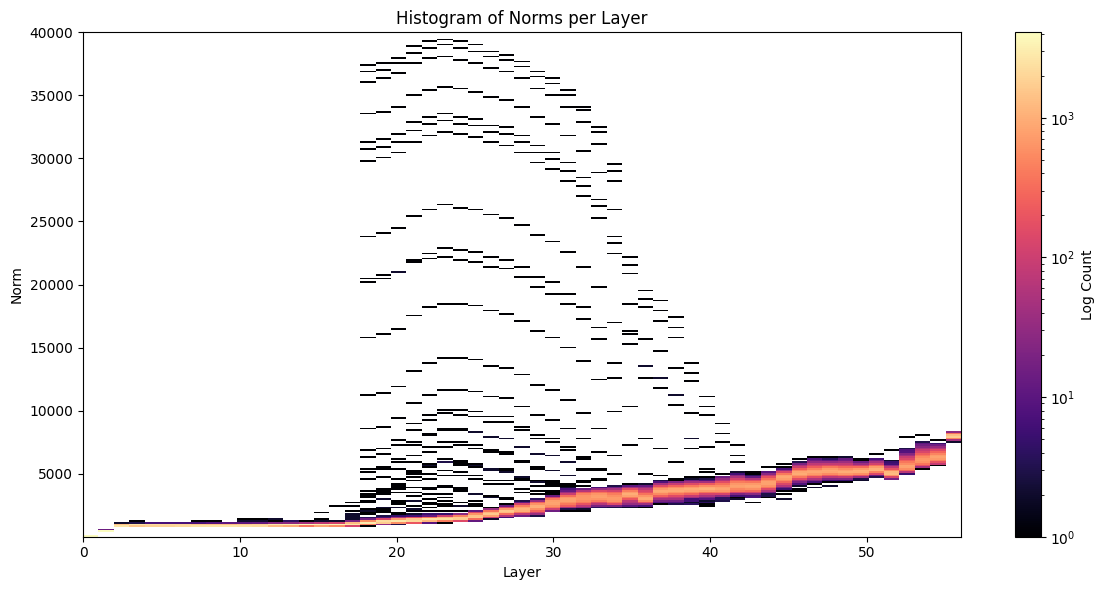

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Config
num_layers = 57
layers = np.arange(num_layers)

# Your actual norm values per layer
norms_image_tokens = [norm_tokens(image_stream + image_act) for image_stream, image_act in zip(cache_pirate["image_residual"],  cache_pirate["image_activation"])]
norms_image_tokens += [norm_tokens((text_image_stream + text_image_act)[:, 512:, :]) for text_image_stream, text_image_act in zip(cache_pirate["text_image_residual"], cache_pirate["text_image_activation"])]

assert len(norms_image_tokens) == num_layers

# Binning
norm_min = 1      # avoid 0 for log scale y-axis
norm_max = 40000  # based on your max
num_bins = 300
norm_bins = np.linspace(norm_min, norm_max, num_bins + 1)  # linear bins for now
# Optionally switch to log bins for better alignment:
# norm_bins = np.logspace(np.log10(norm_min), np.log10(norm_max), num_bins + 1)

# Histogram matrix
density = np.zeros((num_bins, num_layers))
for i, values in enumerate(norms_image_tokens):
    hist, _ = np.histogram(values, bins=norm_bins)
    density[:, i] = hist

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

im = ax.imshow(
    density,
    origin='lower',
    aspect='auto',
    extent=[layers[0], layers[-1], norm_bins[0], norm_bins[-1]],
    cmap='magma',
    norm=LogNorm(vmin=1, vmax=np.max(density)),
    interpolation='nearest'
)

# ax.set_yscale('log')  # back to log y-axis
ax.set_xlabel('Layer')
ax.set_ylabel('Norm')
ax.set_title('Histogram of Norms per Layer')
fig.colorbar(im, ax=ax, label='Log Count')
plt.tight_layout()
plt.show()


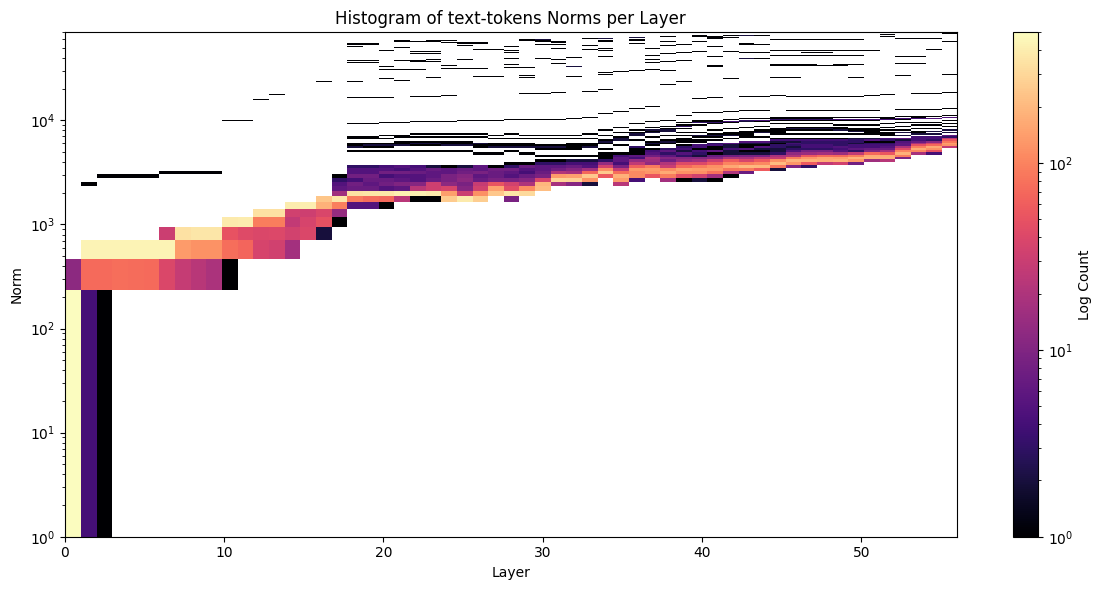

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Config
num_layers = 57
layers = np.arange(num_layers)

# Your actual norm values per layer
norms_text_tokens = [norm_tokens(image_stream + image_act) for image_stream, image_act in zip(cache_pirate["text_residual"],  cache_pirate["text_activation"])]
norms_text_tokens += [norm_tokens((text_image_stream + text_image_act)[:, :512, :]) for text_image_stream, text_image_act in zip(cache_pirate["text_image_residual"], cache_pirate["text_image_activation"])]

assert len(norms_image_tokens) == num_layers

# Binning
norm_min = 1      # avoid 0 for log scale y-axis
norm_max = 70000  # based on your max
num_bins = 300
norm_bins = np.linspace(norm_min, norm_max, num_bins + 1)  # linear bins for now
# Optionally switch to log bins for better alignment:
# norm_bins = np.logspace(np.log10(norm_min), np.log10(norm_max), num_bins + 1)

# Histogram matrix
density = np.zeros((num_bins, num_layers))
for i, values in enumerate(norms_text_tokens):
    hist, _ = np.histogram(values, bins=norm_bins)
    density[:, i] = hist

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

im = ax.imshow(
    density,
    origin='lower',
    aspect='auto',
    extent=[layers[0], layers[-1], norm_bins[0], norm_bins[-1]],
    cmap='magma',
    norm=LogNorm(vmin=1, vmax=np.max(density)),
    interpolation='nearest'
)

ax.set_yscale('log')  # back to log y-axis
ax.set_xlabel('Layer')
ax.set_ylabel('Norm')
ax.set_title('Histogram of text-tokens Norms per Layer')
fig.colorbar(im, ax=ax, label='Log Count')
plt.tight_layout()
plt.show()


# Let's have a look at Queries and keys

In [10]:
from attention_cache import set_cached_attention_processor

cache = set_cached_attention_processor(pipe)
_ = single_layer_ablation_with_cache(Ablation.get_ablation("nothing"), prompt=PROMPT_PIRATE, layer=2, vanilla_prompt=PROMPT_PIRATE)[1]

In [14]:
cache["query"][0].shape

torch.Size([1, 24, 4608, 128])